# 2. Data loading and pre-processing

## Loading the dataset and creating data loaders

In [49]:
import torchvision
import torchvision.transforms as transforms
import torch
import numpy as np


# We move our tensor to the GPU if available
if (torch.cuda.is_available()):
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(DEVICE)
original_set = torchvision.datasets.MNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)]))

test_set = torchvision.datasets.MNIST(root="./", download=True,
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0,1)]))


cpu


In [50]:
from torch.utils.data import random_split, Dataset, DataLoader

## Train-val split
train_set, val_set = random_split(original_set, [50000, 10000])

print(f"Size of the training set: {len(train_set)}")
print(f"Size of the validation set: {len(val_set)}")
print(f"Size of the test set: {len(test_set)}")

## Create the data loaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

Size of the training set: 50000
Size of the validation set: 10000
Size of the test set: 10000


In [51]:
classes = {0: "Zero", 1: "One", 2: "Two", 3: "Three", 4: "Four", 5: "Five", 6: "Six", 7: "Seven", 8: "Eight", 9: "Nine"}
class_names = ["Zero","One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]


## Visualizing samples

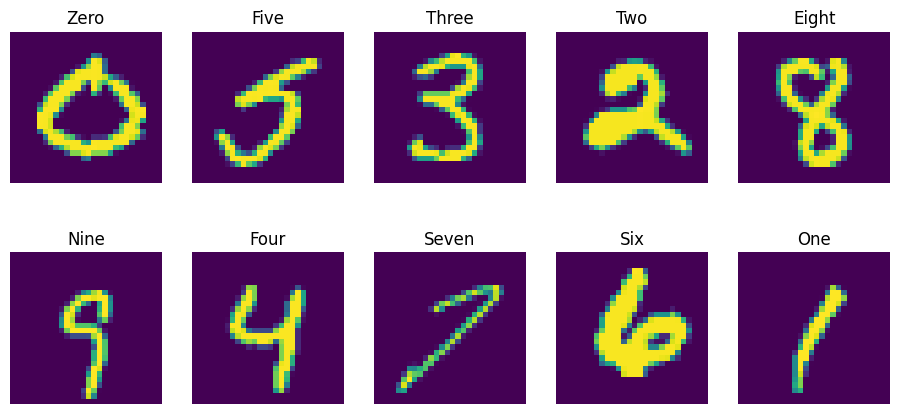

In [52]:
import matplotlib.pyplot as plt
import itertools

def imshow(img_array, labels, classes):
    figure, axs = plt.subplots(2, 5)
    counter = 0
    for i in range(2):
      for j in range(5):
        imgTmp = torch.transpose(img_array[counter],0,2)
        axs[i][j].imshow(torch.transpose(imgTmp, 0, 1).reshape((28,28)))
        axs[i][j].set_title(classes[distinct_classes[counter]])
        axs[i][j].axis('off')
        counter += 1
    plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=1.5,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)
    plt.show()



data_iter = iter(train_loader)

images, labels = next(data_iter)

## Visualize one sample from each class

distinct_images = []
distinct_classes = []
counter = 0
for i in range(len(labels)):
    if int(labels[i]) not in distinct_classes:
        counter += 1
        distinct_images.append(images[i])
        distinct_classes.append(int(labels[i]))
    if counter == 10:
        break
imshow(distinct_images, distinct_classes, classes)

# 3. Model implementation and training

## The model class

In [53]:
import torch.nn as nn
import torch.nn.functional as F

# Fully-connected neural network
class FC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FC, self).__init__()
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 100),
            nn.ReLU(True),
            nn.Linear(100, 30),
            nn.ReLU(True),
            nn.Linear(30, 10),
        )

    def forward(self, x):
        # The forward pass
        x = self.flatten(x)
        x = self.encoder_lin(x)
        x = torch.sigmoid(x)
        return x

## Training

In [54]:
## The method for fitting an epoch of data to the model

def fit(model, train_loader, optimizer, criterion):
    model.train()   # Training mode (allow weight updates)
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    for i, data in enumerate(train_loader):
        counter += 1
        data, target = data[0].to(DEVICE), data[1].to(DEVICE)
        data = data.reshape(-1, 28*28)    ## Reshape the image data for the fully-connected NN
        total += target.size(0)
        optimizer.zero_grad()   # Reset gradients
        outputs = model(data)   # Calculate outputs
        loss = criterion(outputs, target)     ## Calculate Loss
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item() ## Number of correct preds
        loss.backward()   ## Backpropage the loss and calculate the gradients
        optimizer.step()   ## Update the weights using backpropagation

    train_loss = train_running_loss / counter ## Total epoch loss
    train_accuracy = 100. * train_running_correct / total ## Mean epoch accuracy
    return train_loss, train_accuracy

In [55]:
## The method for evaluating the validation data

def validation(model, data_loader, criterion):
    model.eval()    ## Evaluation mode (do not allow weight updates)
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    for i, data in enumerate(data_loader):
        counter += 1
        data, target = data[0].to(DEVICE), data[1].to(DEVICE)
        data = data.reshape(-1, 28*28)
        total += target.size(0)
        outputs = model(data)
        loss = criterion(outputs, target)
        val_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        val_running_correct += (preds == target).sum().item()
        ## No backprop here (because we are validating)

    val_loss = val_running_loss / counter
    val_accuracy = 100. * val_running_correct / total
    return val_loss, val_accuracy

In [56]:
import torch.optim as optim
import time

## The main method for training the model through epochs
def train(hparams, train_loader, val_loader):

    model = FC(28*28, 256, 10)
    model.to(DEVICE) ## Model from CPU to GPU
    optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])  ## Adam optimized

    criterion = nn.CrossEntropyLoss() ## Cross entropy loss
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    start = time.time()
    ## Loop over epochs
    for epoch in range(hparams['epochs']):
        print(f"Epoch {epoch+1} of {hparams['epochs']}")
        train_epoch_loss, train_epoch_accuracy = fit(
            model, train_loader, optimizer, criterion
        ) ## Fit the model using the training set
        val_epoch_loss, val_epoch_accuracy = validation(model, val_loader, criterion)   ## Evaluate the model on the val set
        train_loss.append(train_epoch_loss)
        train_accuracy.append(train_epoch_accuracy)

        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f},\
         Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}")

    end = time.time()

    print(f"Training time: {(end-start)/60:.3f} minutes")
    return model, train_loss, train_accuracy, val_loss, val_accuracy

In [57]:
# Hyperparameters dict
hparams = {'batch_size': 256, 'lr': 2e-3, 'epochs': 15}
model = FC(28*28, 256, 10)
model.to(DEVICE)
from torchsummary import summary
summary(model, (1, 28*28), batch_size=hparams['batch_size'])  ## Model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [256, 784]               0
            Linear-2                 [256, 256]         200,960
              ReLU-3                 [256, 256]               0
            Linear-4                 [256, 100]          25,700
              ReLU-5                 [256, 100]               0
            Linear-6                  [256, 30]           3,030
              ReLU-7                  [256, 30]               0
            Linear-8                  [256, 10]             310
Total params: 230,000
Trainable params: 230,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 3.06
Params size (MB): 0.88
Estimated Total Size (MB): 4.70
----------------------------------------------------------------


In [58]:
model, train_loss, train_accuracy, val_loss, val_accuracy = train(hparams, train_loader, val_loader) ### train the model

Epoch 1 of 15
Train Loss: 1.6597, Train Acc: 76.82,         Val Loss: 1.5468, Val Acc: 85.74
Epoch 2 of 15
Train Loss: 1.5213, Train Acc: 92.33,         Val Loss: 1.5107, Val Acc: 94.41
Epoch 3 of 15
Train Loss: 1.5009, Train Acc: 95.42,         Val Loss: 1.5003, Val Acc: 95.04
Epoch 4 of 15
Train Loss: 1.4919, Train Acc: 96.37,         Val Loss: 1.4948, Val Acc: 95.88
Epoch 5 of 15
Train Loss: 1.4853, Train Acc: 97.18,         Val Loss: 1.4917, Val Acc: 96.57
Epoch 6 of 15
Train Loss: 1.4810, Train Acc: 97.68,         Val Loss: 1.4884, Val Acc: 96.58
Epoch 7 of 15
Train Loss: 1.4788, Train Acc: 97.95,         Val Loss: 1.4863, Val Acc: 96.73
Epoch 8 of 15
Train Loss: 1.4758, Train Acc: 98.30,         Val Loss: 1.4847, Val Acc: 97.22
Epoch 9 of 15
Train Loss: 1.4740, Train Acc: 98.54,         Val Loss: 1.4852, Val Acc: 96.90
Epoch 10 of 15
Train Loss: 1.4728, Train Acc: 98.64,         Val Loss: 1.4854, Val Acc: 97.17
Epoch 11 of 15
Train Loss: 1.4715, Train Acc: 98.83,         Val Loss

In [59]:
torch.save(model.state_dict(), 'saved_model')

# 4. Post-processing and testing

## Loading the saved model

In [ ]:
model = FC(28*28, 256, 10)
model.load_state_dict(torch.load('saved_model'))
model.to(DEVICE)

FC(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (softm): Softmax(dim=1)
)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Utility functions

In [ ]:
## Utility method to plot a confusion matrix (cm) given the sklearn cm object and the class names

def plot_confusion_matrix(cm, target_names, title, normalize):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
import copy

## Main post-processing method
def detailed_analysis(model, n_classes, class_names, train_loader,\
                      test_loader, train_accuracy, train_loss, val_accuracy, val_loss):
    model.eval()  # No training in post-processing

    ### Train
    loader = train_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_train = [0.] * n_classes
    y_true = []
    y_pred = []
    # No grad calculations needed in post-processing
    with torch.no_grad():
      for images, labels in loader:
        images = images.reshape((-1,28*28))
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)    ## For calculating class-wise accuracies
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
                class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_train[i] = class_corrects[i]/class_totals[i]   ## Class-wise accuracies

    cm_train = confusion_matrix(y_true, y_pred)   ## Sklearn confusion matrix object
    y_true_train = copy.deepcopy(y_true)
    y_pred_train = copy.deepcopy(y_pred)

    ### Test
    loader = test_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_test = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        images = images.reshape((-1,28*28))
        outputs = model(images.to(DEVICE))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_test[i] = class_corrects[i]/class_totals[i]
    cm_test = confusion_matrix(y_true, y_pred)
    y_true_test = copy.deepcopy(y_true)
    y_pred_test = copy.deepcopy(y_pred)

    ## Plots
    fig, axs = plt.subplots(3, figsize=(30,20))
    axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss')
    axs[0].plot(list(range(1,len(val_loss)+1)), val_loss, label='Val Loss')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(list(range(1,len(train_accuracy)+1)), train_accuracy, label='Train Acc')
    axs[1].plot(list(range(1,len(val_accuracy)+1)), val_accuracy, label='Val Acc')
    axs[1].set_title('Acc per Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acc')
    axs[1].legend()

    x = np.arange(len(class_names))
    width = 0.2
    trains = axs[2].bar(x, class_accs_train, width, label='Train')
    tests = axs[2].bar(x + width, class_accs_test, width, label = 'Test')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Final Accuracy of Each Class (Train and Test)')
    axs[2].set_xticks(x+width/2)
    axs[2].set_xticklabels(class_names)
    axs[2].legend()
    plt.show()

    return cm_train, cm_test, y_true_train, y_pred_train, y_true_test, y_pred_test

## Plotting the results and testing

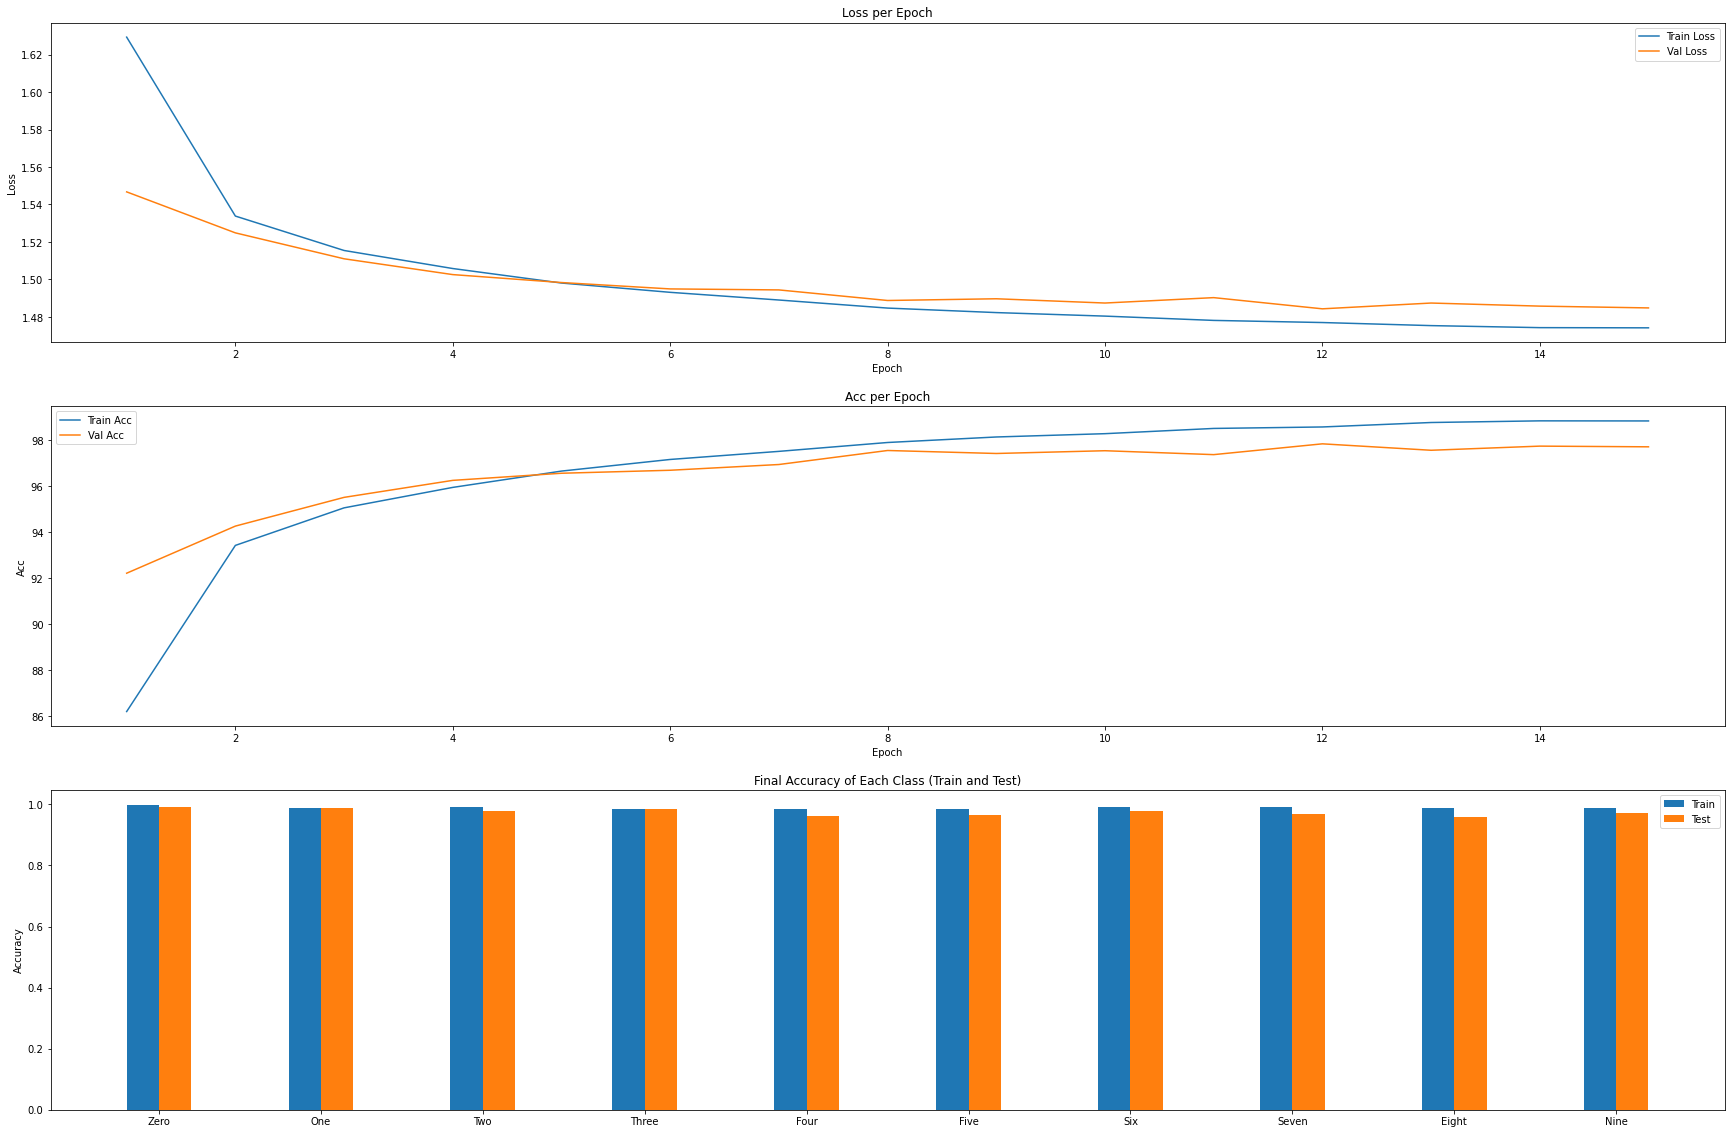

In [ ]:
cm_train, cm_test, y_true_train, y_pred_train, y_true_test, y_pred_test = detailed_analysis(model,\
                                                        10, class_names, train_loader, test_loader,\
                                                         train_accuracy, train_loss, val_accuracy, val_loss)    ## Post-processing

## Plotting the confusion matrices

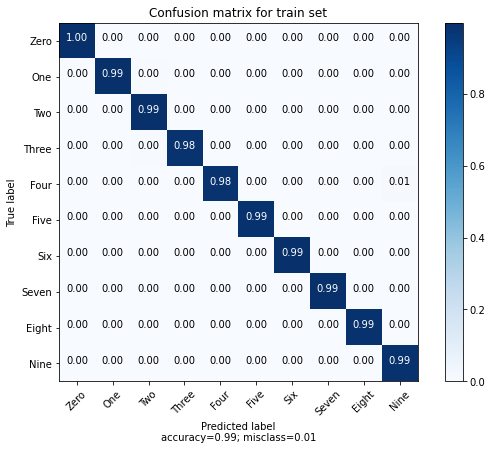

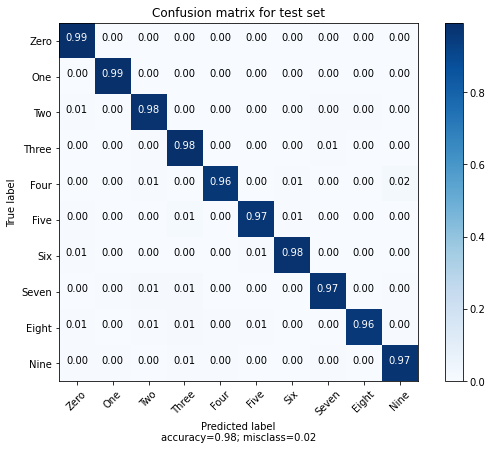

In [ ]:
plot_confusion_matrix(cm_train, class_names, title='Confusion matrix for train set', normalize=True)
print()
plot_confusion_matrix(cm_test, class_names, title='Confusion matrix for test set', normalize=True)

## Classification reports

In [ ]:
print('Train set classification report')
print(classification_report(y_true_train, y_pred_train, target_names=class_names))

Train set classification report
              precision    recall  f1-score   support

        Zero       0.99      1.00      0.99      4903
         One       0.99      0.99      0.99      5572
         Two       0.98      0.99      0.99      4965
       Three       0.99      0.98      0.99      5122
        Four       0.99      0.98      0.99      4900
        Five       0.99      0.99      0.99      4561
         Six       0.99      0.99      0.99      4920
       Seven       0.99      0.99      0.99      5220
       Eight       0.99      0.99      0.99      4889
        Nine       0.98      0.99      0.98      4948

    accuracy                           0.99     50000
   macro avg       0.99      0.99      0.99     50000
weighted avg       0.99      0.99      0.99     50000



In [ ]:
print('Test set classification report')
print(classification_report(y_true_test, y_pred_test, target_names=class_names))

Test set classification report
              precision    recall  f1-score   support

        Zero       0.97      0.99      0.98       980
         One       0.99      0.99      0.99      1135
         Two       0.97      0.98      0.97      1032
       Three       0.95      0.98      0.97      1010
        Four       0.98      0.96      0.97       982
        Five       0.98      0.97      0.97       892
         Six       0.98      0.98      0.98       958
       Seven       0.97      0.97      0.97      1028
       Eight       0.98      0.96      0.97       974
        Nine       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.97      0.98     10000
weighted avg       0.98      0.98      0.98     10000

